In [1]:
import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D,MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
import pandas as pd
import tensorflow as tf
import keras
import pickle

In [5]:
test_list=os.listdir('input/dermnet/test') 
#len test_list 
train_list=os.listdir('input/dermnet/train')
#len(train_list) 23

#SORTING THEM FOR REFERENCE
train_list.sort()
test_list.sort()
#viewing items
#test_list[0:5]

print(train_list)

['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


In [6]:
train_list_mod=['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Eczema Photos', 'Nail Fungus and other Nail Disease', 'Psoriasis pictures Lichen Planus and related diseases']

In [7]:
len(train_list_mod)

6

In [8]:
def data_dictionary():
    path_train="input/dermnet/train/"
    path_test="input/dermnet/test/"
    list_train=train_list_mod#os.listdir(path_train)
    train_dictionary={"image_path":[],"target":[]}
    test_dictionary={"image_path":[],"target":[]}
    k=0
    for i in list_train:
        path_disease_train=path_train+i
        path_disease_test=path_test+i
        image_list_train=os.listdir(path_disease_train)
        image_list_test=os.listdir(path_disease_test)
        for j in image_list_train:
            img_path_train=path_disease_train+"/"+j
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(k) 
        for m in image_list_test :
            img_path_test=path_disease_test+"/"+m
            test_dictionary["image_path"].append(img_path_test)
            test_dictionary['target'].append(k)
        k+=1 
    test_df=pd.DataFrame(test_dictionary)
    train_df=pd.DataFrame(train_dictionary)
        
    return  train_df,test_df

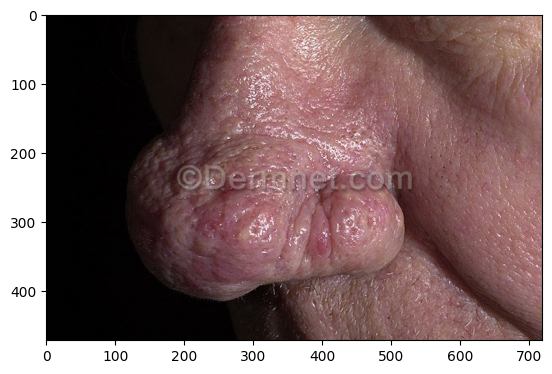

In [9]:
img=Image.open("input/dermnet/test/Acne and Rosacea Photos/07Rhinophyma1.jpg")
plt.imshow(img)

In [10]:
def load_data(input_size=(100,100)):
    images=[]
    images2=[]
    train_df,test_df=data_dictionary()
    for i in train_df['image_path']:
        img=cv2.imread(i)
        img=cv2.resize(img,input_size)
        images.append(img)
    y_train=np.asarray(train_df['target'])
    x_train=np.asarray(images)
    for i in test_df['image_path']:
        img=cv2.imread(i)
        img=cv2.resize(img,input_size)
        images2.append(img)
    y_test=np.asarray(test_df['target'])
    x_test=np.asarray(images2)
    return x_train,x_test,y_train,y_test



In [11]:
x_train,x_test,y_train,y_test=load_data(input_size=(100,100))

In [12]:
from tensorflow.keras.applications import  VGG19
from tensorflow.keras.models import Model
from keras.applications.vgg19 import preprocess_input


In [13]:
vgg16 = VGG19(include_top=False,weights='imagenet')

In [14]:
vgg16.summary()


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
import joblib

In [18]:
# filename="vgg16.sav"
# joblib.dump(vgg16,open(filename,'wb'))
vgg16.save("vgg16.keras")


In [20]:
# vgg19=joblib.load("vgg16.sav")
from keras.models import load_model

loaded_model = load_model("vgg16.keras")


In [21]:
train_img=preprocess_input(x_train)
test_img=preprocess_input(x_test)

In [22]:
features_train=vgg16.predict(train_img)

 17/193 ━━━━━━━━━━━━━━━━━━━━ 5:11 2s/step

: 

In [ ]:
features_test=vgg16.predict(test_img)

In [ ]:
features_train.shape

(6158, 3, 3, 512)

In [ ]:
features_test.shape

(1645, 3, 3, 512)

In [ ]:
num_train=x_train.shape[0]
num_test=x_test.shape[0]


In [ ]:
x_train=features_train.reshape(num_train,4608)
x_test=features_test.reshape(num_test,4608)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense

In [ ]:
model=Sequential([ Dense(1024,activation='relu'),
                   Dense(512,activation='relu'),
                  Dense(256,activation='relu'),
                  Dense(128,activation='relu'),
                  Dense(6,activation='sigmoid'),

])

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
model.fit(x_train,y_train,batch_size=32,epochs=40,validation_data=(x_test,y_test))

Epoch 1/40
193/193 [==============================] - 1s 4ms/step - loss: 1.7872 - accuracy: 0.5091 - val_loss: 1.1553 - val_accuracy: 0.5824
Epoch 2/40
193/193 [==============================] - 1s 3ms/step - loss: 0.8815 - accuracy: 0.6840 - val_loss: 1.1165 - val_accuracy: 0.6109
Epoch 3/40
193/193 [==============================] - 1s 3ms/step - loss: 0.5885 - accuracy: 0.7918 - val_loss: 1.1464 - val_accuracy: 0.6413
Epoch 4/40
193/193 [==============================] - 1s 3ms/step - loss: 0.4351 - accuracy: 0.8535 - val_loss: 1.1254 - val_accuracy: 0.6419
Epoch 5/40
193/193 [==============================] - 1s 3ms/step - loss: 0.3118 - accuracy: 0.8949 - val_loss: 1.3481 - val_accuracy: 0.6565
Epoch 6/40
193/193 [==============================] - 1s 3ms/step - loss: 0.2513 - accuracy: 0.9165 - val_loss: 1.1887 - val_accuracy: 0.6960
Epoch 7/40
193/193 [==============================] - 1s 3ms/step - loss: 0.2123 - accuracy: 0.9307 - val_loss: 1.5095 - val_accuracy: 0.6778
Epoch 

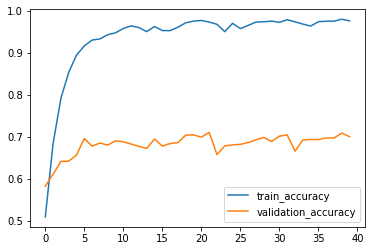

In [ ]:
plt.plot(model.history.history['accuracy'],label="train_accuracy")
plt.plot(model.history.history['val_accuracy'],label="validation_accuracy")
plt.legend()
plt.show()


In [ ]:
    
def load_img(img_path):
    images=[]
    img=cv2.imread(img_path)
    img=cv2.resize(img,(100,100))
    images.append(img)
    x_test=np.asarray(images)
    test_img=preprocess_input(x_test)
    features_test=vgg16.predict(test_img)
    num_test=x_test.shape[0]
    f_img=features_test.reshape(num_test,4608)
    
    return f_img
    

In [ ]:
img=load_img("input/dermnet/test/Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions/actinic-cheilitis-sq-cell-lip-20.jpg")

In [ ]:
np.argmax(model.predict(img))

1

In [ ]:
import pickle

In [ ]:
import os
import tensorflow as tf

# Create the directory if it doesn't exist
save_dir = "saved_model"
os.makedirs(save_dir, exist_ok=True)

# Save the model in two different ways
model.save(os.path.join(save_dir, "skin_model"))  # Save with folder structure
model.save("skin_model.h5")  # Save directly in current directory

# Check if the model files were saved successfully
if os.path.exists(os.path.join(save_dir, "skin_model")):
    print("Model saved successfully in 'saved_model' directory.")
else:
    print("Failed to save the model in 'saved_model' directory.")

if os.path.exists("skin_model.h5"):
    print("Model saved successfully as 'skin_model.h5'.")
else:
    print("Failed to save the model as 'skin_model.h5'.")

# Load the model
loaded_model = tf.keras.models.load_model("skin_model.h5")

# Confirm that the model was loaded successfully
print("Model loaded successfully!")


Model saved successfully in 'saved_model' directory.
Model saved successfully as 'skin_model.h5'.
Model loaded successfully!


In [ ]:
# !mkdir -p saved_model
# model.save('saved_model/skin_model')

In [ ]:
# # filename="skin_model.pkl"
# # joblib.dump(model,open(filename,'wb'))
# # Save the model
# model.save("skin_model.h5")

# # Load the model
# loaded_model = tf.keras.models.load_model("skin_model.h5")


In [ ]:
# new_model = tf.keras.models.load_model('saved_model/skin_model')

# Check its architecture
# loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              4719616   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 5,409,414
Trainable params: 5,409,414
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# np.argmax(loaded_model.predict(img))

1